In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
import torch

In [3]:
import torch.nn.functional as F

In [4]:
data = pd.read_excel("cal_housing.xlsx")

In [5]:
n = 20640
n_train = 12384
n_test = 8256

In [6]:
np.random.seed(1)


In [7]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41,880,129,322,126,8.3252,452600
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500
2,-122.24,37.85,52,1467,190,496,177,7.2574,352100
3,-122.25,37.85,52,1274,235,558,219,5.6431,341300
4,-122.25,37.85,52,1627,280,565,259,3.8462,342200


In [8]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['median_house_value'],axis=1), data['median_house_value'], test_size=0.4)

In [9]:
#y_train = np.log(y_train)

In [51]:
#y_test = np.log(y_test)

In [9]:
scaler = preprocessing.StandardScaler()

In [10]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
scaled_X_train=scaler.transform(X_train)/np.sqrt(n_train)

In [12]:
#put scaled data back into a dataframe
#X_train = pd.DataFrame(data=scaled_X_train,columns = X_train.columns,index=X_train.index)
X_train = scaled_X_train

In [13]:
scaler.fit(X_test)
scaled_X_test=scaler.transform(X_test)/np.sqrt(n_test)
X_test = scaled_X_test
#X_test = pd.DataFrame(data=scaled_X_test,columns = X_test.columns,index=X_test.index)

In [14]:
#X_test = scaled_X_test

In [15]:
scaled_y_train = preprocessing.scale(np.log(np.array(y_train)).reshape(n_train,1))/np.sqrt(n_train)
y_train = scaled_y_train

In [16]:
#y_train = scaled_y_train

In [17]:
scaled_y_test = preprocessing.scale(np.log(np.array(y_test)).reshape(n_test,1))/np.sqrt(n_test)
#y_test = pd.DataFrame(data=scaled_y_test,index=y_test.index)

In [18]:
y_test = scaled_y_test

In [19]:
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

In [20]:
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [40]:
class Net(torch.nn.Module):
    def __init__(self,n_feature,n_hidden,n_output):
        super(Net,self).__init__() #继承__init__功能
        #定义每层的形式
        self.hidden1 = torch.nn.Linear(n_feature,n_hidden[0])
        self.hidden2 = torch.nn.Linear(n_hidden[0],n_hidden[1])
        #self.hidden3 = torch.nn.Linear(n_hidden[1],n_hidden[2])
        self.predict = torch.nn.Linear(n_hidden[1],n_output)
        
    def forward(self,x):
        x = F.tanh(self.hidden1(x))
        x = F.tanh(self.hidden2(x))
        #x = F.tanh(self.hidden3(x))
        x = self.predict(x)
        return x
    

In [51]:
net = Net(n_feature = 8,n_hidden=[6,3],n_output = 1)

In [52]:
net.double()

Net(
  (hidden1): Linear(in_features=8, out_features=6, bias=True)
  (hidden2): Linear(in_features=6, out_features=3, bias=True)
  (predict): Linear(in_features=3, out_features=1, bias=True)
)

In [53]:
print(net)

Net(
  (hidden1): Linear(in_features=8, out_features=6, bias=True)
  (hidden2): Linear(in_features=6, out_features=3, bias=True)
  (predict): Linear(in_features=3, out_features=1, bias=True)
)


In [54]:
#optimizer
loss_dict = []
R2adj = []
optimizer = torch.optim.SGD(net.parameters(),lr=0.2)
loss_func = torch.nn.MSELoss()

for t in range(100):
    prediction = net(X_train)
    
    loss = loss_func(prediction,y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #loss value
    loss_dict.append(loss.item())
    
    
    
    

In [42]:
#loss value
y_pred = net(X_test)

#R2adj
loss = loss_func(y_pred,y_test)

In [26]:
loss

tensor(8.4108e-05, dtype=torch.float64, grad_fn=<MseLossBackward>)

In [46]:
SST = sum((y_test-torch.mean(y_test))**2)
SSRes = sum((y_test-y_pred)**2)
R2 = 1-SSRes/SST
R2adj = (n_test-1)/(n_test-8)*(R2 - 1)+1

RuntimeError: The size of tensor a (8256) must match the size of tensor b (12384) at non-singleton dimension 0

In [55]:
y_pred = net(X_train)

In [56]:
SST = sum((y_train-torch.mean(y_train))**2)
SSRes = sum((y_train-y_pred)**2)
R2 = 1-SSRes/SST
R2adj = (n_train-1)/(n_train-8)*(R2 - 1)+1

In [57]:
R2

tensor([-0.0063], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [58]:
R2adj

tensor([-0.0068], dtype=torch.float64, grad_fn=<AddBackward0>)

In [59]:
loss

tensor(8.1257e-05, dtype=torch.float64, grad_fn=<MseLossBackward>)

In [54]:
R2

tensor([0.0131], dtype=torch.float64, grad_fn=<RsubBackward1>)

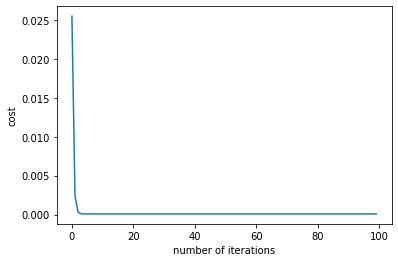

In [60]:
plt.plot(loss_dict)
plt.xlabel("number of iterations")
plt.ylabel('cost')
plt.savefig("NN.png")

In [54]:
sum((y_test-torch.mean(y_test))**2)

tensor([1.0000], dtype=torch.float64)

In [55]:
y_test-torch.mean(y_test)

tensor([[ 0.0135],
        [-0.0176],
        [ 0.0050],
        ...,
        [ 0.0003],
        [ 0.0041],
        [ 0.0085]], dtype=torch.float64)

In [34]:
torch.mean(y_test)

tensor(-1.7004e-17, dtype=torch.float64)